In this notebook file, we are going to show how expensive data obtained from numerical simulations can be combined with low-fidelity data obtained from constitutive equations to build a multi-fidelity surrogate to predict the rheological properties of a suspension of fibers. We will be using the Gaussian process (GP) and neural networks (NN) to build physics-informed GP and NN. First, we will focus on the single-fidelity model; then, we will switch to multi-fidelity models.

Installing and importing the required modules

In [10]:
!pip install --upgrade GPy

#################importing the libraries##############
import GPy
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
import seaborn as sns
import random
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Single fidelity DNN**

Here, we read the high-fidelity train and test dataset and use them for training and testing a single-fidelity network.

In [112]:
data_train=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_train_short.csv")
data_test=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_test.csv")

data_train.dropna(inplace=True,axis=1, how='all')
#data_test.dropna(inplace=True)
X_DNN_train=data_train.drop(['viscosity','Re'], axis=1).to_numpy()
y_DNN_train=data_train[["viscosity"]].to_numpy()
X_DNN_test=data_test.drop(['viscosity','Re'], axis=1).to_numpy()
y_DNN_test=data_test[["viscosity"]].to_numpy()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scale_new=MinMaxScaler()
X_DNN_train_scaled = scale_new.fit_transform(X_DNN_train)
X_DNN_test_scaled = scale_new.transform(X_DNN_test)
X_DNN_torch_train=torch.tensor(X_DNN_train_scaled).float()
y_DNN_torch_train=torch.tensor(y_DNN_train).float()
X_DNN_torch_test=torch.tensor(X_DNN_test_scaled).float()
y_DNN_torch_test=torch.tensor(y_DNN_test).float()


**Data inputs and outputs**


Shear rate, aspect ratio (AR), roughness rigidity, and volume fraction are the inputs to all the models. The viscosity is the output of the models. 


In [106]:
data_train.head()

,shear rate,Re,AR,roughness,rigidity,volume fraction,viscosity
0,1,1,16,0.05,0.02,0.05,5.00
1,2,1,16,0.05,0.02,0.05,4.00
2,5,1,16,0.05,0.02,0.05,2.45
3,10,1,16,0.05,0.02,0.05,1.84
4,30,1,16,0.05,0.02,0.05,1.70


In [107]:
weight_decay=0

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
N_n=20 #number of nuerons
N_l=2  #number of hidden layers

net_DNN = torch.nn.Sequential(
        torch.nn.Linear(X_DNN_torch_train.shape[1], N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n,N_n),
        torch.nn.ReLU(),
#        torch.nn.Linear(N_n, N_n),
#       torch.nn.ReLU(),
#        torch.nn.Linear(N_n, N_n),
#        torch.nn.ReLU(),
#        torch.nn.Linear(N_n, N_n),
#        torch.nn.ReLU(),
        torch.nn.Linear(N_n, 1),

    )

optimizer_DNN = torch.optim.Adam(net_DNN.parameters(), lr=0.001, weight_decay=weight_decay)
loss_func = torch.nn.MSELoss()  

loss_DNN_train_tally=[]
loss_DNN_test_tally=[]
epochs=range(1,10000)
for t in epochs: 
    prediction_DNN_train = net_DNN(X_DNN_torch_train)
    prediction_DNN_test= net_DNN(X_DNN_torch_test)
    loss_DNN_train=loss_func(prediction_DNN_train, y_DNN_torch_train)     
    loss_DNN_train_tally.append(loss_DNN_train.detach().numpy())
    loss_DNN_test=loss_func(prediction_DNN_test, y_DNN_torch_test)
    loss_DNN_test_tally.append(loss_DNN_test.detach().numpy())     
    optimizer_DNN.zero_grad()  
    loss_DNN_train.backward()        
    optimizer_DNN.step()        
      

print('DNN_loss=',np.round_(loss_DNN_test_tally[-1],4))
print('DNN_R2score=',np.round_(r2_score(y_DNN_test, prediction_DNN_test.detach().numpy()),4))

DNN_loss= 16.1298
DNN_R2score= 0.7575


**Creating low-fidelity dataset**

We fitted the Casson constitutive equation shown below to the high-fidelity data to determine the coefficients ($\tau_0$, $k_c$) of casson equation as a function of suspension properties, i.e., aspect ratio (AR), roughness rigidity, and volume fraction.

$$ \sqrt{\tau}=\sqrt{\tau_0}+\sqrt{k_c \dot{\Gamma}} $$ 

After obtaining the coefficients as a function of suspension properties, we will use Neural Networks to create a model that predicts the coefficients of the Casson constitutive equations as a function of suspension properties. Then, we will use the constitutive equations to generate the low-fidelity data.




In [67]:
###########Casson
data_train=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/coefficients_Casson_train.csv")
data_test=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/coefficients_Casson_test.csv")
X_train=data_train[['AR','roughness','rigidity','volume fraction']]
multiplier=1
y_train=data_train[['tau_0', 'k']]*multiplier
X_test=data_test[['AR','roughness','rigidity','volume fraction']]
y_test=data_test[['tau_0', 'k']]*multiplier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)
X_torch_train=torch.tensor(X_train_scaled).float()
y_torch_train=torch.tensor(y_train.to_numpy()).float()
X_torch_test=torch.tensor(X_test_scaled).float()
y_torch_test=torch.tensor(y_test.to_numpy()).float()


X_test.head(5)

data_train_coeff=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/coefficients_Casson_train.csv")
data_test_coeff=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/coefficients_Casson_test.csv")
X_coeff_train=data_train_coeff[['AR','roughness','rigidity','volume fraction']].to_numpy()
y_coeff_train=data_train_coeff[['tau_0', 'k']].to_numpy()
X_coeff_test=data_test_coeff[['AR','roughness','rigidity','volume fraction']].to_numpy()
y_coeff_test=data_test_coeff[['tau_0', 'k']].to_numpy()
data_train_coeff.head(5)


,AR,roughness,rigidity,volume fraction,tau_0,k
0,16.0,0.050,0.02,0.05,1.478502,1.105007
1,16.0,0.050,0.02,0.07,2.946580,1.127341
2,16.0,0.050,0.02,0.15,10.228933,4.262997
3,16.0,0.005,0.02,0.10,2.859709,3.641155
4,16.0,0.025,0.02,0.10,4.678758,3.919547


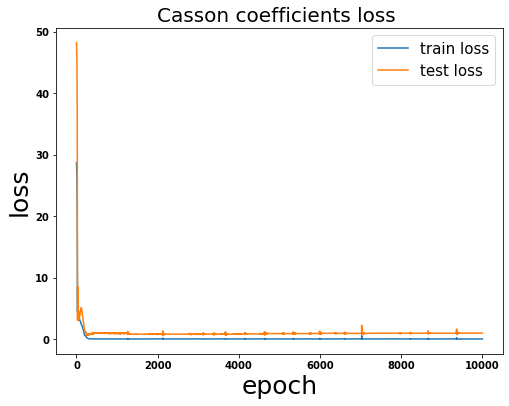

In [40]:
###Training a neural network for predicting the coefficients of the Casson constitutive equations 

weight_decay=0.0
import random
random.seed(0)
torch.manual_seed(10)
torch.cuda.manual_seed(0)
np.random.seed(0)

N_n=100
net = torch.nn.Sequential(
        torch.nn.Linear(X_torch_train.shape[1], N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, y_torch_train.shape[1]),

    )
# print(net)  # net architecture
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# train the network
loss_train=[]
loss_test=[]
epochs=range(1,10000)
for t in epochs: 
    prediction = net(X_torch_train)
    prediction_test= net(X_torch_test)
    loss=loss_func(prediction, y_torch_train)     # input x and predict based on x
    loss_train.append(loss.detach().numpy())
    loss_test.append(loss_func(prediction_test, y_torch_test).detach().numpy())     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
plt.subplots(figsize=(8,6))
plt.plot(epochs,loss_train,label='train loss')
plt.plot(epochs,loss_test,label='test loss')
plt.xlabel(r'epoch', fontsize=25)
plt.ylabel(r'loss', fontsize=25)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.title('Power Law coefficients loss ',fontsize=20)
plt.title('Carreau-Yasuda coefficients loss ',fontsize=20)
plt.title('Casson coefficients loss ',fontsize=20)
plt.legend(fontsize=15)
#plt.tight_layout()
#plt.savefig('loss_PL_coefficients',dpi=500)
#plt.savefig('Carreau-Yasuda_coefficients',dpi=500)

In [43]:
##########creating the low fidelity data############
import random
from random import choice

random.seed(0)
np.random.seed(70)
samp=1000
#gamma=np.random.random(samp)*2000

gammas=[1, 2, 5, 10, 30, 50, 100, 300, 600, 1000]
gamma=[]
for i in range(samp):
    gamma.append(choice(gammas))
gamma=np.array(gamma)

phi=[0.05,0.07,0.1,0.12,0.15,0.2,0.3,0.4]
#phi=np.arange(0.05,0.41,0.01)

roughness=np.random.random(samp)*0.1
rigidity=np.random.random(samp)*0.1
#phi=np.random.random(samp)*0.4

ARS=[]
AR=[10,16]
for i in range(samp):
    ARS.append(choice(AR))
AR=np.array(ARS)

phis=[]
for i in range(samp):
    phis.append(choice(phi))
phi=np.array(phis)

print(len(roughness))
print(len(phi))
print(gamma.shape)
low_fidel_input=pd.DataFrame({'shear rate': gamma, 'AR':AR,'roughness':roughness, 'rigidity':rigidity, 'volume fraction':phi})


X=low_fidel_input.iloc[:,1:].to_numpy()

X_scaled = scale.transform(X)
X_torch=torch.tensor(X_scaled).float()

low_fidel_coeff_NN_pred=net(X_torch).detach().numpy()
tau_0=low_fidel_coeff_NN_pred[:,0]
k=low_fidel_coeff_NN_pred[:,1]

viscosity_low_fidel= (np.sqrt(tau_0)+np.sqrt(k*gamma))**2/gamma
low_fidel_input['viscosity']=viscosity_low_fidel


low_fidel_input=low_fidel_input.iloc[0:samp,:]

1000
1000
(1000,)


 /usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:X does not have valid feature names, but MinMaxScaler was fitted with feature names


**Multi-fidelity Neural Networks**

Here we used two neural networks consecutively where the first network is used as the low-fidelity network and is trained with low-fidelity data, and the second network is the high-fidelity network trained with the high-fidelity data in addition to the output of the low-fidelity network, which is fed into the high-fidelity network as an extra input.

In [109]:
X_train_low_fidel=low_fidel_input.drop(['viscosity'], axis=1).to_numpy()
y_train_low_fidel=low_fidel_input[["viscosity"]].to_numpy()
data_train=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_train_short.csv")
data_test=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_test.csv")
X_train_high_fidel=data_train.drop(['viscosity','Re'], axis=1).to_numpy()
y_train_high_fidel=data_train[["viscosity"]].to_numpy()
X_test_high_fidel=data_test.drop(['viscosity','Re'], axis=1).to_numpy()
y_test_high_fidel=data_test[["viscosity"]].to_numpy()

X_show=data_train.drop(['Re','AR'], axis=1)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()

X_train_low_fidel_scaled = scale.fit_transform(X_train_low_fidel)
X_train_high_fidel_scaled = scale.transform(X_train_high_fidel)
X_test_high_fidel_scaled = scale.transform(X_test_high_fidel)

"""X_train_low_fidel_scaled = X_train_low_fidel
X_train_high_fidel_scaled = X_train_high_fidel
X_test_high_fidel_scaled = X_test_high_fidel"""

#torch.manual_seed(0)    # reproducible
#import random
#random.seed(0)

X_torch_low_fidel_train=torch.tensor(X_train_low_fidel_scaled).float()
y_torch_low_fidel_train=torch.tensor(y_train_low_fidel).float()
X_torch_high_fidel_train=torch.tensor(X_train_high_fidel_scaled).float()
y_torch_high_fidel_train=torch.tensor(y_train_high_fidel).float()
X_torch_high_fidel_test=torch.tensor(X_test_high_fidel_scaled).float()
y_torch_high_fidel_test=torch.tensor(y_test_high_fidel).float()

In [110]:
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
N_n=20
N_l=2
weight_decay=0.0
deghat=2
net_low_fidel = torch.nn.Sequential(
        torch.nn.Linear(X_torch_low_fidel_train.shape[1], N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
        torch.nn.Linear(N_n, N_n),
        torch.nn.ReLU(),
       # torch.nn.Linear(N_n, N_n),
       # torch.nn.ReLU(),
        torch.nn.Linear(N_n, 1))

class Net_high_fidel(torch.nn.Module):
      def __init__(self):
          super(Net_high_fidel, self).__init__()
          self.hidden = torch.nn.Linear(X_torch_low_fidel_train.shape[1]+1,N_n)   # initial layer
          self.hidden_2 = torch.nn.Linear(N_n,N_n)
          self.predict = torch.nn.Linear(N_n, 1)  # output layer
        
      def forward(self, x):
          x_nl = self.predict(F.relu(self.hidden_2(F.relu(self.hidden(x)))))
          x_l = self.predict(self.hidden(x))             # linear output
          return x_l+x_nl

N_n=5

net_high_fidel=Net_high_fidel()
optimizer_low_fidel = torch.optim.Adam(net_low_fidel.parameters(), lr=0.01)
optimizer_high_fidel = torch.optim.Adam(net_high_fidel.parameters(), lr=0.01)
optimizer= torch.optim.Adam(list(net_high_fidel.parameters())+list(net_low_fidel.parameters()), lr=0.001, weight_decay=weight_decay)


loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# train the network
loss_low_fidel_train_tally=[]
loss_high_fidel_test_tally=[]
loss_high_fidel_train_tally=[]
epochs=range(1,10000)
for t in epochs: 
    prediction_low_fidel_train = net_low_fidel(X_torch_low_fidel_train)
    loss_low_fidel_train=loss_func(prediction_low_fidel_train , y_torch_low_fidel_train)   
    loss_low_fidel_train_tally.append(loss_low_fidel_train.detach().numpy().item())

    X_torch_high_fidel_train_new=torch.cat((X_torch_high_fidel_train, net_low_fidel(X_torch_high_fidel_train)), 1)
    X_torch_high_fidel_test_new=torch.cat((X_torch_high_fidel_test, net_low_fidel(X_torch_high_fidel_test)), 1)
    prediction_high_fidel_train=net_high_fidel(X_torch_high_fidel_train_new)
    prediction_high_fidel_test=net_high_fidel(X_torch_high_fidel_test_new)
    loss_high_fidel_train=loss_func(prediction_high_fidel_train, y_torch_high_fidel_train)   
    loss_high_fidel_train_tally.append(loss_high_fidel_train.detach().numpy().item())
    loss_high_fidel_test=loss_func(prediction_high_fidel_test, y_torch_high_fidel_test)   
    loss_high_fidel_test_tally.append(loss_high_fidel_test.detach().numpy().item())

    loss=loss_low_fidel_train+loss_high_fidel_train
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
   

R^2 socer= 0.8815


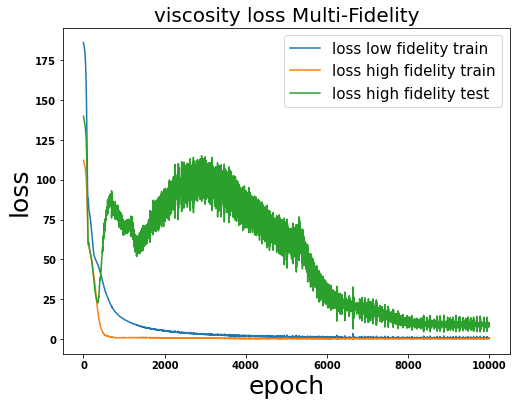

In [111]:
print('R^2 socer=',np.round_(r2_score( y_test_high_fidel,prediction_high_fidel_test.detach().numpy()),4))
plt.subplots(figsize=(8,6))
plt.plot(epochs,loss_low_fidel_train_tally,label='loss low fidelity train')
plt.plot(epochs,loss_high_fidel_train_tally,label='loss high fidelity train')
plt.plot(epochs,loss_high_fidel_test_tally,label='loss high fidelity test')

plt.xlabel(r'epoch', fontsize=25)
plt.ylabel(r'loss', fontsize=25)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.title('viscosity loss Multi-Fidelity',fontsize=20)
plt.legend(fontsize=15)

**Single fidelity GP**

Here, we read the high-fidelity train and test dataset and use them for training and testing a single-fidelity Gaussian process.

In [113]:
data_train=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_train_short.csv")
data_test=pd.read_csv("/content/drive/MyDrive/Rheology/Data_github/Data_highfidelity_test.csv")


data_train.dropna(inplace=True,axis=1, how='all')
#data_test.dropna(inplace=True)
X2=data_train.drop(['viscosity','Re'], axis=1).to_numpy()
Y2=data_train[["viscosity"]].to_numpy()
Xtest=data_test.drop(['viscosity','Re'], axis=1).to_numpy()
Ytest=data_test[["viscosity"]].to_numpy()



In [114]:
random.seed(0)
np.random.seed(0)

dim = X2.shape[1]

kernel='RatQuad'
random.seed(0)
np.random.seed(0)
k4=GPy.kern.RatQuad(dim,ARD=True)

#kernel='RBF'
#k4=GPy.kern.RBF(dim,ARD = True)
m4 = GPy.models.GPRegression(X=X2, Y=Y2, kernel=k4, noise_var=0)

start = time.time()
m4[".*Gaussian_noise"] = m4.Y.var()*0.001
m4[".*Gaussian_noise"].fix()## we don't want the algorithm to optimize the epsilon,  y=f+epsilon for our data epsioln is zero. however, for numerical stability we set it a small value 

m4.optimize(max_iters = 100)

m4.optimize_restarts(5, optimizer = "bfgs",  max_iters = 100) #do this with different initial conditions for better results

end = time.time()


mu4, v4 = m4.predict(Xtest)

r2_test_GP=r2_score(Ytest,mu4)
test_loss=mean_squared_error(mu4, Ytest)


print('GP_loss=',np.round_(test_loss,4))
print('GP_R2score=',np.round_(r2_test_GP,4))

Optimization restart 1/5, f = 129.67117806761328
Optimization restart 2/5, f = 228.5387761264438
Optimization restart 3/5, f = 130.1321902500773
Optimization restart 4/5, f = 130.84339437341626
Optimization restart 5/5, f = 184.7431981009795
GP_loss= 31.3098
GP_R2score= 0.5293


**Multi-fidelity Gaussian Process (MFGP)**

Here we used two GPs consecutively where the first network is used as the low-fidelity network and is trained with low-fidelity data, and the second network is the high-fidelity network trained with the high-fidelity data in addition to the output of the low-fidelity network, which is fed into the high-fidelity network as an extra input.

In [117]:
X_train_low_fidel=low_fidel_input.drop(['viscosity'], axis=1).to_numpy()
y_train_low_fidel=low_fidel_input[["viscosity"]].to_numpy()
X_train_high_fidel=data_train.drop(['viscosity','Re'], axis=1).to_numpy()
y_train_high_fidel=data_train[["viscosity"]].to_numpy()
X_test_high_fidel=data_test.drop(['viscosity','Re'], axis=1).to_numpy()
y_test_high_fidel=data_test[["viscosity"]].to_numpy()
num_of_low_fidel_data=len(X_train_low_fidel[:,0])


In [118]:
dim = X_train_high_fidel.shape[1]
active_dimensions = np.arange(0,dim)
seed=0
X1 = X_train_low_fidel
X2 = X_train_high_fidel
Xtest = X_test_high_fidel

Y1 = y_train_low_fidel
Y2 = y_train_high_fidel
Exact = y_test_high_fidel

N1 = X1.shape[0]
N2 = X2.shape[0]

deghat=2




start = time.time()

''' Train level 1 '''
kernel='Matern32'
random.seed(0)
np.random.seed(0)
k1 = k1=GPy.kern.Matern52(dim,ARD=True)
m1 = GPy.models.GPRegression(X=X1, Y=Y1, kernel=k1)

m1[".*Gaussian_noise"] = m1.Y.var()*0.01
m1[".*Gaussian_noise"].fix()

m1.optimize(max_iters = 200)

m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()

m1.optimize_restarts(5, optimizer = "bfgs",  max_iters = 100)

mu1, v1 = m1.predict(X2)

''' Train level 2 '''
XX = np.hstack((X2, mu1))

k2 = GPy.kern.Matern32(1, active_dims = [dim])*GPy.kern.Matern32(dim, active_dims = active_dimensions, ARD = True) \
    + GPy.kern.Matern32(dim, active_dims = active_dimensions, ARD = True)


m2 = GPy.models.GPRegression(X=XX, Y=Y2, kernel=k2)

m2[".*Gaussian_noise"] = m2.Y.var()*0.01
m2[".*Gaussian_noise"].fix()

m2.optimize(max_iters = 200)

m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()

m2.optimize_restarts(5, optimizer = "bfgs",  max_iters = 100)

end = time.time()
print("Training AR-GP done in %f seconds" % (end - start))

# Predict at test points
nsamples = 1000
ntest = Xtest.shape[0]
mu0, C0 = m1.predict(Xtest, full_cov=True)
Z = np.random.multivariate_normal(mu0.flatten(),C0,nsamples)
tmp_m = np.zeros((nsamples,ntest))
tmp_v = np.zeros((nsamples,ntest))



# push samples through f_2
for i in range(0,nsamples):
    mu, v = m2.predict(np.hstack((Xtest, Z[i,:][:,None])))
    tmp_m[i,:] = mu.flatten()
    tmp_v[i,:] = v.flatten()

# get mean and variance at X3
mu2 = np.mean(tmp_m, axis = 0)
v2 = np.mean(tmp_v, axis = 0) + np.var(tmp_m, axis = 0)
mu2 = mu2[:,None]
v2 = np.abs(v2[:,None])



r2_test_MFGP=r2_score(Exact,mu2)
test_loss=mean_squared_error(mu2, Exact)

print('MFGP_loss=',np.round_(test_loss,4))
print('MFGP_R2score=',np.round_(r2_test_MFGP,4))


Optimization restart 1/5, f = 1637.7915439814967
Optimization restart 2/5, f = 1637.7915438862692
Optimization restart 3/5, f = 1637.7915442493363
Optimization restart 4/5, f = 1637.791554306687
Optimization restart 5/5, f = 1682.8876973821016


Optimization restart 1/5, f = 131.42814710275525
Optimization restart 2/5, f = 118.8217853848341
Optimization restart 3/5, f = 124.39223629491329
Optimization restart 4/5, f = 106.74563890348243
Optimization restart 5/5, f = 111.57039643316736
Training AR-GP done in 212.484645 seconds
MFGP_loss= 7.6604
MFGP_R2score= 0.8848
